# Finite element method: More general Poisson equation in 2D with Dirichlet boundary conditions

Consider the following problem:
$$
\left\{
\begin{aligned}
-\nabla \cdot (c(x,y) \nabla u) &= f \;  &\quad \text{in } \Omega = (0,1)^2 \\
u &= 0 \;  &\quad \text{on } \partial \Omega 
\end{aligned}
\right.
$$

Implement the numerical solution of this problem by using piecewise linear finite elements.

Generate triangular meshes of $\overline \Omega$ with different mesh sizes $h$.

To test your implementation, use 
$$
c(x,y) = 0.1 + 0.7x \quad \text{and} \quad f(x,y) = 2\pi^2 \sin(\pi x) \sin(\pi y) \; .
$$
Estimate the numerical error by calculating
$$
e_{2h} = u_{2h} - u_h \; .
$$
Then take the error w.r.t. the maximum norm, and produce a log-log plot.

## Solution

First, we write a function to generate a mesh for the domain $\Omega = (0,1)^2$.

In [112]:
function fem_squaremesh(square,h)
    x0 = square[1]; x1= square[2];
    y0 = square[3]; y1= square[4];
    meshgrid(a, b) = (repeat(a, outer=length(b)), repeat(b, inner=length(a)))
    x,y = meshgrid(x0:h:x1,y0:h:y1)
    node = [x[:] y[:]];

    t = []
    ux = unique(x)
    uy = unique(y)
    Nx = length(ux)
    Ny = length(uy)
    N = Nx * Ny
    for ind = 1:length(x)
        if ind % Nx != 0 && ind+Nx <= N
            push!(t, [ind ind+1 ind+Nx])
        end
        if ind % Nx != 0 && ind-Nx+1 >= 1
            push!(t, [ind-Nx+1 ind ind+1])
        end
    end
    
    nTriangles = length(t)
    tra = zeros(Int64, nTriangles, 3)
    for (ind, v) = enumerate(t)
        tra[ind,:] = v
    end
    
    r = []
    for (ind, point) = enumerate(eachrow(node))
        if point[1] == ux[1] || point[1] == ux[end] || point[2] == uy[1] || point[2] == uy[end]
            push!(r, ind)
        end
    end
    r = Array{Int64, 1}(r)
    
    return tra, r, node
    
end

function generate_mesh(dx)
    return fem_squaremesh([0 1 0 1], dx)
end
;

We use this function to generate a series of meshes.

In [55]:
N_meshes = 7
tvals = []
rvals = []
pvals = []
mesh_sizes = []
for i = 1:N_meshes
    t, r, p = generate_mesh(1//2^(i))
    push!(tvals, t)
    push!(rvals, r)
    push!(pvals, p)
    push!(mesh_sizes, sqrt(2*(1/2^(i))^2))
end

We have to modify the calculation of the element stiffness matrices. To evaluate the integrals on the reference element $\hat K$, we use the quadrature formula
$$
\int_{\hat K} g(\xi, \eta) \; \mathrm d\xi \, \mathrm d\eta = \frac 1 6 \left[ g\left( \frac 1 6, \frac 1 6 \right) + g\left( \frac 2 3 , \frac 1 6 \right) + g\left( \frac 1 6, \frac 2 3 \right) \right] \; .
$$

In [56]:
function gauss_quadrature_deg_2_on_ref(g)
    return 1/6 * (g(1/6, 1/6) + g(2/3, 1/6) + g(1/6, 2/3))
end
;

In [57]:
using LinearAlgebra
function element_stiffness_matrix_load_vector(t, p, el, f, c)
    J = zeros(2,2)
    p0 = p[t[el, 1],:]
    p1 = p[t[el, 2],:]
    p2 = p[t[el, 3],:]
    J[:,1] = p1 - p0
    J[:,2] = p2 - p0
    invJ = inv(J)
    detJ = det(J)
    m = (p0 + p1 + p2) / 3
    
    function g(x,y)
        im = p0 + J * [x;y]
        return c(im[1], im[2])
    end
    A = gauss_quadrature_deg_2_on_ref(g) * abs(detJ) * [-1 -1; 1 0; 0 1] * invJ * invJ' * [-1 1 0; -1 0 1]
    
    function h0(x,y)
        im = p0 + J * [x;y]
        return f(im[1], im[2]) * (1 - x - y)
    end
    function h1(x,y)
        im = p0 + J * [x;y]
        return f(im[1], im[2]) * x
    end
    function h2(x,y)
        im = p0 + J * [x;y]
        return f(im[1], im[2]) * y
    end
    l = zeros(3)
    l[1] = gauss_quadrature_deg_2_on_ref(h0) * abs(detJ)
    l[2] = gauss_quadrature_deg_2_on_ref(h1) * abs(detJ)
    l[3] = gauss_quadrature_deg_2_on_ref(h2) * abs(detJ)
    return A, l
end
;

In [58]:
using SparseArrays
function assemble_stiffness_matrix_load_vector(t, p, r, f, c)
    Nelements = size(t)[1]
    Npoints = size(p)[1]
    A = spzeros(Npoints, Npoints)
    l = zeros(Npoints)
    for el = 1:Nelements
        Ael, lel = element_stiffness_matrix_load_vector(t, p, el, f, c)
        for i = 1:3
            l[t[el,i]] += lel[i]
            for j = 1:3
                A[t[el, i], t[el, j]] += Ael[i,j]
            end
        end
    end
    
    # Set the Dirichlet boundary conditions:
    nzrow_ind, nzcol_ind, _ = findnz(A)
    for (i, j) in zip(nzrow_ind, nzcol_ind)
        if i in r
            if i == j
                A[i,j] = 1.0
            else
                A[i,j] = 0.0
            end 
        end
    end
    for i = 1:Npoints
        if i in r
            l[i] = 0.0
        end
    end
    
    return A, l
end
;

In [59]:
function solve(t, p, r, f, c)
    A, l = assemble_stiffness_matrix_load_vector(t, p, r, f, c)
    A \ l
end
;

In [60]:
f(x,y) = 2 * pi^2 * sin.(pi*x) .* sin.(pi*y);

In [61]:
c(x,y) = 0.1 .+ 0.7 .* x;

In [62]:
numerical_solutions = [solve(t, p, r, f, c) for (t, p, r) in zip(tvals, pvals, rvals)];

In [63]:
using PyPlot
function plot_solution(x, y, numsol, tit)
    fig = figure("pyplot_surfaceplot",figsize=(8,8))
    PyPlot.using3D()
    ax = fig.add_subplot(1,1,1, projection = "3d")
    ax.plot_trisurf(x, y, numsol, linewidth=0, antialiased=false, cmap=get_cmap("inferno"))
    title(tit)
    xlabel("x")
    ylabel("y")
    
end

function plot_solution_contour(x, y, numsol, tit)
    fig = figure("pyplot_surfaceplot", figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    cp = ax.tricontour(x, y, numsol, colors="black")
    ax.clabel(cp, inline=1, fontsize=12)
    title(tit)
    xlabel("x")
    ylabel("y")
end
;

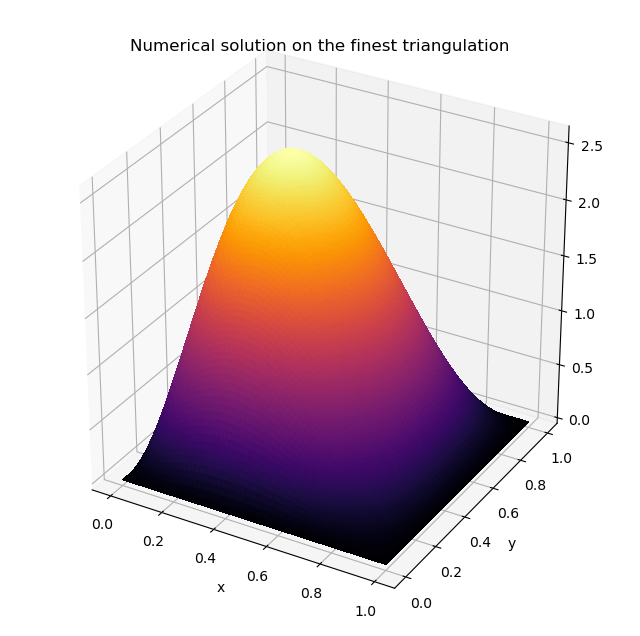

In [65]:
plot_solution(pvals[end][:,1], pvals[end][:,2], numerical_solutions[end], "Numerical solution on the finest triangulation");

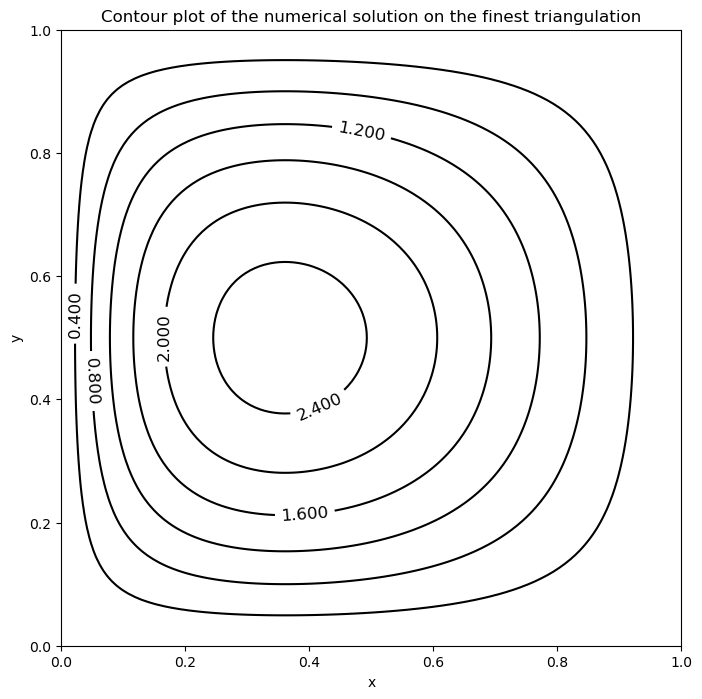

In [71]:
plot_solution_contour(pvals[end][:,1], pvals[end][:,2], numerical_solutions[end], "Contour plot of the numerical solution on the finest triangulation");

In [109]:
function estimate_error(u2h, p2h, uh, ph)
    e2h = similar(u2h)
    for i = 1:length(u2h)
        #j = find(all(ph .== p2h[i, :]', 2))[1] # might be 'dangerous'
        a = ph .== p2h[i,:]'
        j = findfirst(a[:,1] .& a[:,2])
        e2h[i] = u2h[i] - uh[j]
    end
    return maximum(abs, e2h)
end
;

We can now estimate the errors for on all meshes, except for the last one:

In [110]:
estimated_errors = [estimate_error(numerical_solutions[i], pvals[i], numerical_solutions[i+1], pvals[i+1]) for i = 1:length(pvals)-1]

6-element Array{Float64,1}:
 0.3719880505137736   
 0.1291334450712922   
 0.036502904154555704 
 0.009541499140027998 
 0.0024179871312890455
 0.0006063635523920752

Finally, we generate a log-log plot of the error.

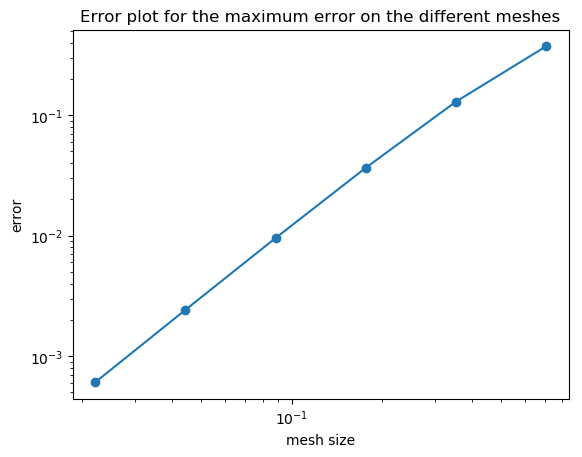

In [111]:
loglog(mesh_sizes[1:end-1], estimated_errors, "-o")
title("Error plot for the maximum error on the different meshes")
xlabel("mesh size")
ylabel("error");